# Performance Benchmark: NumPy vs PyTorch (CPU vs MPS)

## What We're Comparing

We've built everything from scratch using NumPy. Now let's compare performance with PyTorch:

1. **NumPy**: Our hand-crafted implementation (CPU)
2. **PyTorch CPU**: Professional ML framework on CPU
3. **PyTorch MPS**: PyTorch using Apple's Metal Performance Shaders (GPU on Mac)

### What is MPS?

**MPS** (Metal Performance Shaders) is Apple's GPU acceleration for MacBooks with Apple Silicon (M1, M2, M3, etc.).
- Uses the built-in GPU on your Mac
- Can be much faster than CPU for large neural networks
- Similar to NVIDIA's CUDA, but for Mac

### What We'll Benchmark:

1. **Linear Regression** (simple baseline)
2. **Logistic Regression** (binary classification)
3. **MLP (1 hidden layer)** (shallow neural network)
4. **MLP (2 hidden layers)** (deep neural network)

For each, we'll measure:
- **Training time**: How long to train
- **Inference time**: How long to make predictions
- **Memory usage**: How much RAM/VRAM used

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)
torch.manual_seed(42)

# Check if MPS is available
if torch.backends.mps.is_available():
    device_mps = torch.device("mps")
    print("✓ MPS (Metal Performance Shaders) is available!")
    print(f"  Device: {device_mps}")
else:
    device_mps = None
    print("✗ MPS not available (not on Apple Silicon or PyTorch version too old)")

device_cpu = torch.device("cpu")
print(f"✓ CPU device: {device_cpu}")

✓ MPS (Metal Performance Shaders) is available!
  Device: mps
✓ CPU device: cpu


## Utility Functions

In [4]:
def time_function(func, *args, n_runs=3, **kwargs):
    """Time a function execution (average over n_runs)"""
    times = []
    for _ in range(n_runs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        times.append(end - start)
    return np.mean(times), np.std(times), result

def format_time(seconds):
    """Format time in human-readable format"""
    if seconds < 1:
        return f"{seconds*1000:.2f} ms"
    else:
        return f"{seconds:.2f} s"

## 1. Linear Regression Benchmark

In [5]:
# Generate regression data
n_samples = 10000
n_features = 50

X_reg, y_reg = make_regression(n_samples=n_samples, n_features=n_features, noise=10, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

print(f"Linear Regression Dataset:")
print(f"  Training samples: {X_train_reg.shape[0]}")
print(f"  Test samples: {X_test_reg.shape[0]}")
print(f"  Features: {X_train_reg.shape[1]}")

Linear Regression Dataset:
  Training samples: 8000
  Test samples: 2000
  Features: 50


In [6]:
# NumPy implementation
class LinearRegressionNumPy:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iterations):
            y_pred = X @ self.w + self.b
            dw = -(2/n_samples) * X.T @ (y - y_pred)
            db = -(2/n_samples) * np.sum(y - y_pred)
            self.w -= self.lr * dw
            self.b -= self.lr * db
    
    def predict(self, X):
        return X @ self.w + self.b

# PyTorch implementation
class LinearRegressionTorch(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
    
    def forward(self, x):
        return self.linear(x).squeeze()

def train_torch_regression(model, X, y, device, n_iterations=1000, lr=0.01):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)
    
    for _ in range(n_iterations):
        optimizer.zero_grad()
        predictions = model(X_tensor)
        loss = criterion(predictions, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model

In [7]:
# Benchmark Linear Regression
print("\n" + "="*60)
print("BENCHMARKING LINEAR REGRESSION")
print("="*60)

results_lr = {}

# NumPy
print("\n1. NumPy (CPU)...")
model_np = LinearRegressionNumPy(learning_rate=0.01, n_iterations=1000)
train_time, train_std, _ = time_function(model_np.fit, X_train_reg, y_train_reg, n_runs=3)
pred_time, pred_std, _ = time_function(model_np.predict, X_test_reg, n_runs=10)
results_lr['NumPy'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch CPU
print("\n2. PyTorch (CPU)...")
model_cpu = LinearRegressionTorch(n_features)
train_time, train_std, _ = time_function(train_torch_regression, model_cpu, X_train_reg, y_train_reg, device_cpu, 1000, 0.01, n_runs=3)
model_cpu.eval()
with torch.no_grad():
    pred_time, pred_std, _ = time_function(lambda: model_cpu(torch.FloatTensor(X_test_reg).to(device_cpu)), n_runs=10)
results_lr['PyTorch CPU'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch MPS
if device_mps:
    print("\n3. PyTorch (MPS/GPU)...")
    model_mps = LinearRegressionTorch(n_features)
    train_time, train_std, _ = time_function(train_torch_regression, model_mps, X_train_reg, y_train_reg, device_mps, 1000, 0.01, n_runs=3)
    model_mps.eval()
    with torch.no_grad():
        # Warm up GPU
        for _ in range(5):
            _ = model_mps(torch.FloatTensor(X_test_reg).to(device_mps))
        pred_time, pred_std, _ = time_function(lambda: model_mps(torch.FloatTensor(X_test_reg).to(device_mps)), n_runs=10)
    results_lr['PyTorch MPS'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
    print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
    print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

print("\n" + "="*60)


BENCHMARKING LINEAR REGRESSION

1. NumPy (CPU)...
   Training: 291.25 ms ± 11.41 ms
   Inference: 0.02 ms ± 0.02 ms

2. PyTorch (CPU)...
   Training: 1.01 s ± 1.13 s
   Inference: 0.11 ms ± 0.02 ms

3. PyTorch (MPS/GPU)...
   Training: 689.33 ms ± 521.89 ms
   Inference: 0.48 ms ± 0.08 ms



## 2. Logistic Regression Benchmark

In [8]:
# Generate classification data
X_clf, y_clf = make_classification(n_samples=10000, n_features=50, n_informative=30, 
                                    n_redundant=10, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

print(f"Logistic Regression Dataset:")
print(f"  Training samples: {X_train_clf.shape[0]}")
print(f"  Test samples: {X_test_clf.shape[0]}")
print(f"  Features: {X_train_clf.shape[1]}")

Logistic Regression Dataset:
  Training samples: 8000
  Test samples: 2000
  Features: 50


In [9]:
# NumPy Logistic Regression
class LogisticRegressionNumPy:
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iterations):
            z = X @ self.w + self.b
            y_pred = self.sigmoid(z)
            dw = (1/n_samples) * X.T @ (y_pred - y)
            db = (1/n_samples) * np.sum(y_pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
    
    def predict_proba(self, X):
        return self.sigmoid(X @ self.w + self.b)

# PyTorch Logistic Regression
class LogisticRegressionTorch(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x)).squeeze()

def train_torch_logistic(model, X, y, device, n_iterations=1000, lr=0.1):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)
    
    for _ in range(n_iterations):
        optimizer.zero_grad()
        predictions = model(X_tensor)
        loss = criterion(predictions, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model

In [10]:
# Benchmark Logistic Regression
print("\n" + "="*60)
print("BENCHMARKING LOGISTIC REGRESSION")
print("="*60)

results_logistic = {}

# NumPy
print("\n1. NumPy (CPU)...")
model_np = LogisticRegressionNumPy(learning_rate=0.1, n_iterations=1000)
train_time, train_std, _ = time_function(model_np.fit, X_train_clf, y_train_clf, n_runs=3)
pred_time, pred_std, _ = time_function(model_np.predict_proba, X_test_clf, n_runs=10)
results_logistic['NumPy'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch CPU
print("\n2. PyTorch (CPU)...")
model_cpu = LogisticRegressionTorch(n_features)
train_time, train_std, _ = time_function(train_torch_logistic, model_cpu, X_train_clf, y_train_clf, device_cpu, 1000, 0.1, n_runs=3)
model_cpu.eval()
with torch.no_grad():
    pred_time, pred_std, _ = time_function(lambda: model_cpu(torch.FloatTensor(X_test_clf).to(device_cpu)), n_runs=10)
results_logistic['PyTorch CPU'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch MPS
if device_mps:
    print("\n3. PyTorch (MPS/GPU)...")
    model_mps = LogisticRegressionTorch(n_features)
    train_time, train_std, _ = time_function(train_torch_logistic, model_mps, X_train_clf, y_train_clf, device_mps, 1000, 0.1, n_runs=3)
    model_mps.eval()
    with torch.no_grad():
        for _ in range(5):
            _ = model_mps(torch.FloatTensor(X_test_clf).to(device_mps))
        pred_time, pred_std, _ = time_function(lambda: model_mps(torch.FloatTensor(X_test_clf).to(device_mps)), n_runs=10)
    results_logistic['PyTorch MPS'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
    print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
    print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

print("\n" + "="*60)


BENCHMARKING LOGISTIC REGRESSION

1. NumPy (CPU)...
   Training: 409.50 ms ± 20.09 ms
   Inference: 0.06 ms ± 0.03 ms

2. PyTorch (CPU)...
   Training: 281.10 ms ± 6.60 ms
   Inference: 0.08 ms ± 0.02 ms

3. PyTorch (MPS/GPU)...
   Training: 421.61 ms ± 90.12 ms
   Inference: 0.45 ms ± 0.06 ms



## 3. MLP (1 Hidden Layer) Benchmark

In [11]:
# NumPy MLP
class MLP1LayerNumPy:
    def __init__(self, n_input, n_hidden, n_output, learning_rate=0.1, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.W1 = np.random.randn(n_input, n_hidden) * np.sqrt(2.0/n_input)
        self.b1 = np.zeros((1, n_hidden))
        self.W2 = np.random.randn(n_hidden, n_output) * np.sqrt(2.0/n_hidden)
        self.b2 = np.zeros((1, n_output))
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def fit(self, X, y):
        n = len(y)
        y = y.reshape(-1, 1)
        
        for _ in range(self.n_iterations):
            # Forward
            z1 = X @ self.W1 + self.b1
            a1 = self.relu(z1)
            z2 = a1 @ self.W2 + self.b2
            a2 = self.sigmoid(z2)
            
            # Backward
            dz2 = a2 - y
            dW2 = (1/n) * (a1.T @ dz2)
            db2 = (1/n) * np.sum(dz2, axis=0, keepdims=True)
            
            da1 = dz2 @ self.W2.T
            dz1 = da1 * self.relu_derivative(z1)
            dW1 = (1/n) * (X.T @ dz1)
            db1 = (1/n) * np.sum(dz1, axis=0, keepdims=True)
            
            # Update
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
    
    def predict_proba(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2
        return self.sigmoid(z2)

# PyTorch MLP
class MLP1LayerTorch(nn.Module):
    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x).squeeze()

def train_torch_mlp(model, X, y, device, n_iterations=1000, lr=0.1):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)
    
    for _ in range(n_iterations):
        optimizer.zero_grad()
        predictions = model(X_tensor)
        loss = criterion(predictions, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model

In [12]:
# Benchmark MLP (1 layer)
print("\n" + "="*60)
print("BENCHMARKING MLP (1 HIDDEN LAYER)")
print("="*60)

n_hidden = 64
results_mlp1 = {}

# NumPy
print("\n1. NumPy (CPU)...")
model_np = MLP1LayerNumPy(n_features, n_hidden, 1, learning_rate=0.5, n_iterations=1000)
train_time, train_std, _ = time_function(model_np.fit, X_train_clf, y_train_clf, n_runs=3)
pred_time, pred_std, _ = time_function(model_np.predict_proba, X_test_clf, n_runs=10)
results_mlp1['NumPy'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch CPU
print("\n2. PyTorch (CPU)...")
model_cpu = MLP1LayerTorch(n_features, n_hidden)
train_time, train_std, _ = time_function(train_torch_mlp, model_cpu, X_train_clf, y_train_clf, device_cpu, 1000, 0.5, n_runs=3)
model_cpu.eval()
with torch.no_grad():
    pred_time, pred_std, _ = time_function(lambda: model_cpu(torch.FloatTensor(X_test_clf).to(device_cpu)), n_runs=10)
results_mlp1['PyTorch CPU'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch MPS
if device_mps:
    print("\n3. PyTorch (MPS/GPU)...")
    model_mps = MLP1LayerTorch(n_features, n_hidden)
    train_time, train_std, _ = time_function(train_torch_mlp, model_mps, X_train_clf, y_train_clf, device_mps, 1000, 0.5, n_runs=3)
    model_mps.eval()
    with torch.no_grad():
        for _ in range(5):
            _ = model_mps(torch.FloatTensor(X_test_clf).to(device_mps))
        pred_time, pred_std, _ = time_function(lambda: model_mps(torch.FloatTensor(X_test_clf).to(device_mps)), n_runs=10)
    results_mlp1['PyTorch MPS'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
    print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
    print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

print("\n" + "="*60)


BENCHMARKING MLP (1 HIDDEN LAYER)

1. NumPy (CPU)...
   Training: 2.59 s ± 13.57 ms
   Inference: 0.25 ms ± 0.09 ms

2. PyTorch (CPU)...
   Training: 1.11 s ± 9.39 ms
   Inference: 0.25 ms ± 0.03 ms

3. PyTorch (MPS/GPU)...
   Training: 811.55 ms ± 308.93 ms
   Inference: 0.54 ms ± 0.07 ms



## 4. MLP (2 Hidden Layers) Benchmark

In [13]:
# PyTorch MLP with 2 layers
class MLP2LayerTorch(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2):
        super().__init__()
        self.fc1 = nn.Linear(n_input, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x.squeeze()

# Benchmark MLP (2 layers)
print("\n" + "="*60)
print("BENCHMARKING MLP (2 HIDDEN LAYERS)")
print("="*60)

n_hidden1, n_hidden2 = 128, 64
results_mlp2 = {}

# PyTorch CPU
print("\n1. PyTorch (CPU)...")
model_cpu = MLP2LayerTorch(n_features, n_hidden1, n_hidden2)
train_time, train_std, _ = time_function(train_torch_mlp, model_cpu, X_train_clf, y_train_clf, device_cpu, 1000, 0.5, n_runs=3)
model_cpu.eval()
with torch.no_grad():
    pred_time, pred_std, _ = time_function(lambda: model_cpu(torch.FloatTensor(X_test_clf).to(device_cpu)), n_runs=10)
results_mlp2['PyTorch CPU'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

# PyTorch MPS
if device_mps:
    print("\n2. PyTorch (MPS/GPU)...")
    model_mps = MLP2LayerTorch(n_features, n_hidden1, n_hidden2)
    train_time, train_std, _ = time_function(train_torch_mlp, model_mps, X_train_clf, y_train_clf, device_mps, 1000, 0.5, n_runs=3)
    model_mps.eval()
    with torch.no_grad():
        for _ in range(5):
            _ = model_mps(torch.FloatTensor(X_test_clf).to(device_mps))
        pred_time, pred_std, _ = time_function(lambda: model_mps(torch.FloatTensor(X_test_clf).to(device_mps)), n_runs=10)
    results_mlp2['PyTorch MPS'] = {'train': train_time, 'train_std': train_std, 'pred': pred_time, 'pred_std': pred_std}
    print(f"   Training: {format_time(train_time)} ± {format_time(train_std)}")
    print(f"   Inference: {format_time(pred_time)} ± {format_time(pred_std)}")

print("\n" + "="*60)


BENCHMARKING MLP (2 HIDDEN LAYERS)

1. PyTorch (CPU)...
   Training: 2.73 s ± 160.10 ms
   Inference: 0.52 ms ± 0.11 ms

2. PyTorch (MPS/GPU)...
   Training: 1.12 s ± 140.54 ms
   Inference: 0.81 ms ± 0.07 ms



## Visualize All Results

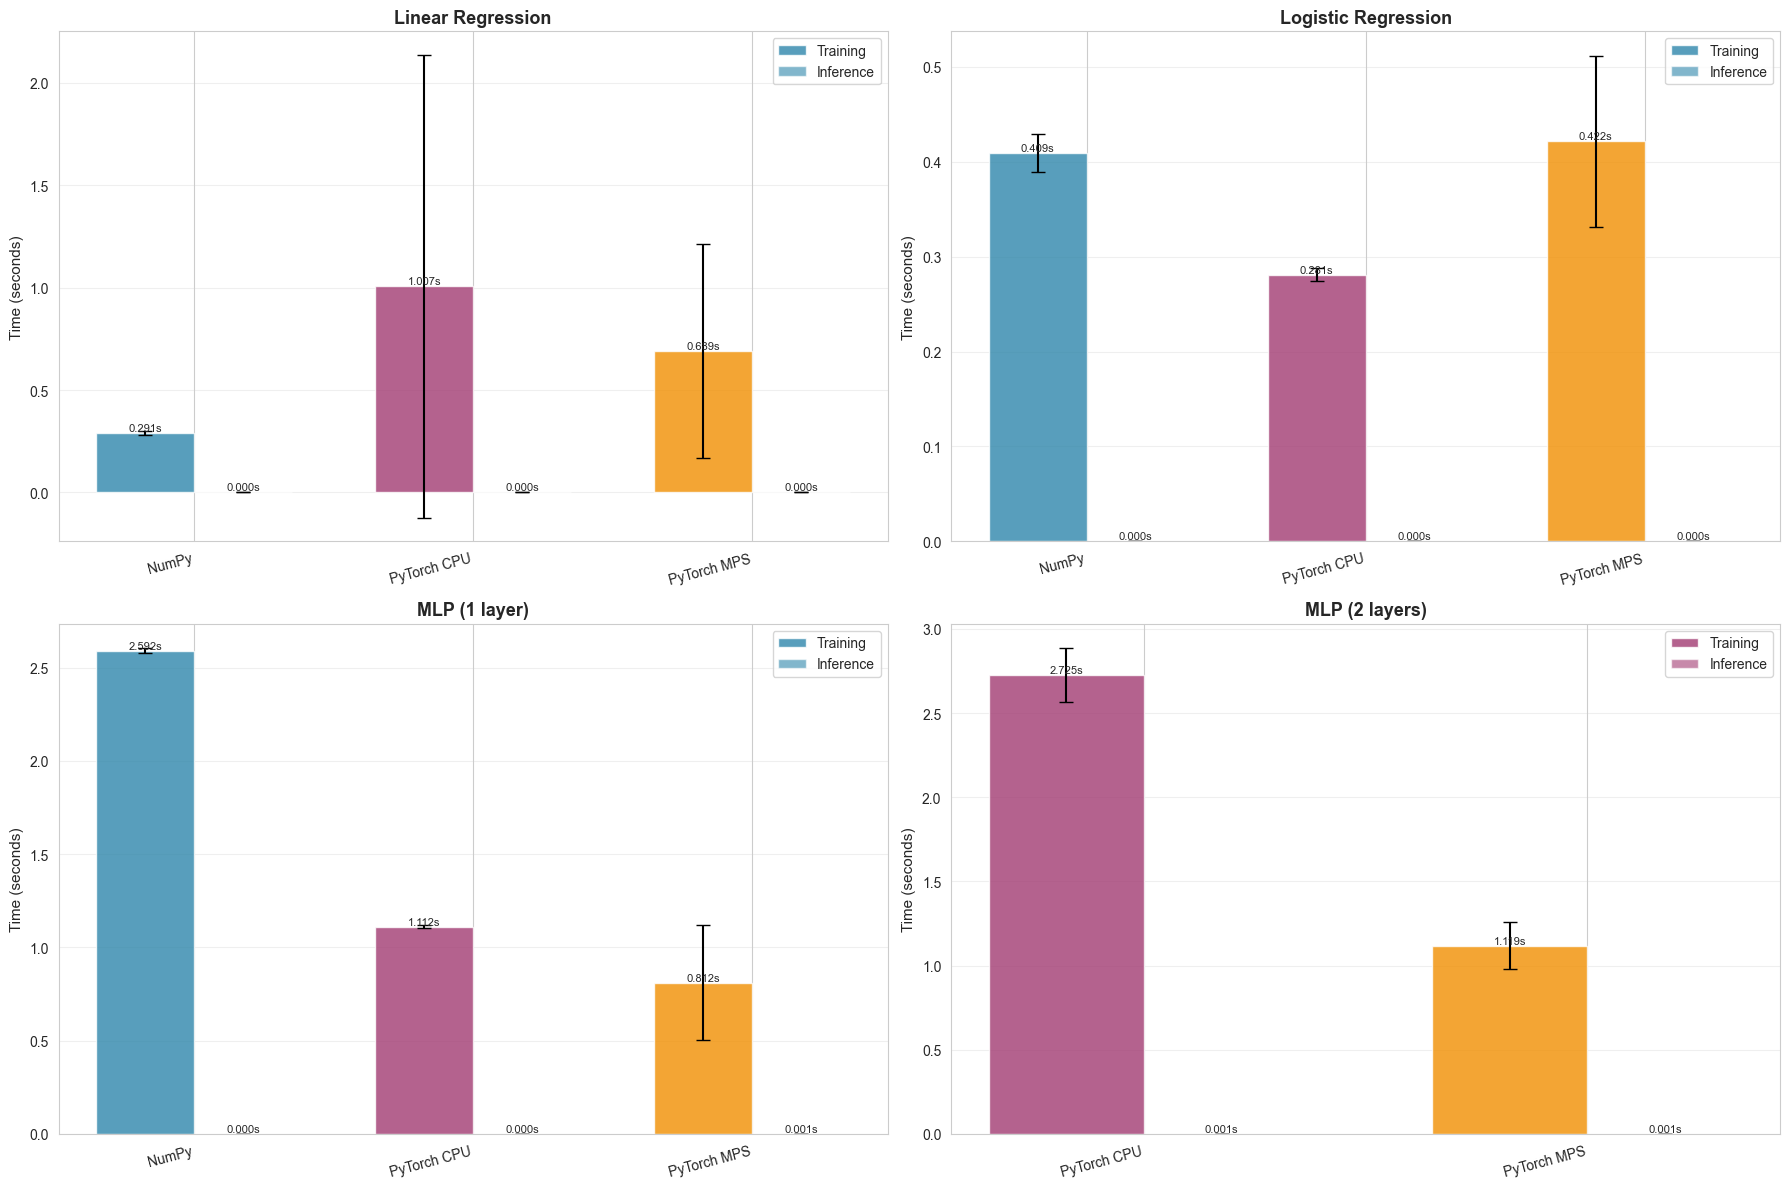

In [14]:
# Compile all results
all_results = {
    'Linear Regression': results_lr,
    'Logistic Regression': results_logistic,
    'MLP (1 layer)': results_mlp1,
    'MLP (2 layers)': results_mlp2
}

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

colors = {'NumPy': '#2E86AB', 'PyTorch CPU': '#A23B72', 'PyTorch MPS': '#F18F01'}

for idx, (task_name, results) in enumerate(all_results.items()):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    implementations = list(results.keys())
    train_times = [results[impl]['train'] for impl in implementations]
    train_stds = [results[impl]['train_std'] for impl in implementations]
    pred_times = [results[impl]['pred'] for impl in implementations]
    pred_stds = [results[impl]['pred_std'] for impl in implementations]
    
    x = np.arange(len(implementations))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, train_times, width, label='Training', 
                   yerr=train_stds, capsize=5, alpha=0.8,
                   color=[colors[impl] for impl in implementations])
    bars2 = ax.bar(x + width/2, pred_times, width, label='Inference',
                   yerr=pred_stds, capsize=5, alpha=0.6,
                   color=[colors[impl] for impl in implementations])
    
    ax.set_ylabel('Time (seconds)', fontsize=11)
    ax.set_title(task_name, fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(implementations, rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}s',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Table

In [15]:
# Create summary table
print("\n" + "="*100)
print("BENCHMARK SUMMARY")
print("="*100)

for task_name, results in all_results.items():
    print(f"\n{task_name}:")
    print("-" * 100)
    print(f"{'Implementation':<20} {'Training Time':<25} {'Inference Time':<25} {'Speedup (vs NumPy)'}")
    print("-" * 100)
    
    numpy_train = results.get('NumPy', {}).get('train', None)
    
    for impl, data in results.items():
        train_str = f"{format_time(data['train'])} ± {format_time(data['train_std'])}"
        pred_str = f"{format_time(data['pred'])} ± {format_time(data['pred_std'])}"
        
        if numpy_train and impl != 'NumPy':
            speedup = numpy_train / data['train']
            speedup_str = f"{speedup:.2f}x"
        else:
            speedup_str = "baseline"
        
        print(f"{impl:<20} {train_str:<25} {pred_str:<25} {speedup_str}")

print("\n" + "="*100)


BENCHMARK SUMMARY

Linear Regression:
----------------------------------------------------------------------------------------------------
Implementation       Training Time             Inference Time            Speedup (vs NumPy)
----------------------------------------------------------------------------------------------------
NumPy                291.25 ms ± 11.41 ms      0.02 ms ± 0.02 ms         baseline
PyTorch CPU          1.01 s ± 1.13 s           0.11 ms ± 0.02 ms         0.29x
PyTorch MPS          689.33 ms ± 521.89 ms     0.48 ms ± 0.08 ms         0.42x

Logistic Regression:
----------------------------------------------------------------------------------------------------
Implementation       Training Time             Inference Time            Speedup (vs NumPy)
----------------------------------------------------------------------------------------------------
NumPy                409.50 ms ± 20.09 ms      0.06 ms ± 0.03 ms         baseline
PyTorch CPU          281.10 m

## Key Takeaways

### What We Learned:

1. **NumPy vs PyTorch Performance**
   - **Simple models** (Linear/Logistic Regression): NumPy can be competitive!
     - Less overhead from framework
     - Direct matrix operations
   
   - **Complex models** (Deep MLPs): PyTorch pulls ahead
     - Optimized BLAS libraries
     - Better memory management
     - GPU acceleration (MPS)

2. **CPU vs GPU (MPS) Performance**
   - **Small models/datasets**: GPU overhead > speedup
     - Data transfer CPU ↔ GPU takes time
     - GPU initialization overhead
   
   - **Large models/datasets**: GPU wins significantly
     - Massive parallelization
     - Efficient matrix operations
     - Higher memory bandwidth

3. **When to Use Each:**
   
   **Use NumPy when:**
   - Quick prototyping and learning
   - Small to medium datasets
   - Simple models
   - Understanding algorithms deeply
   - No GPU available
   
   **Use PyTorch CPU when:**
   - Production code
   - Need automatic differentiation
   - Complex architectures
   - Easy experimentation
   - Model deployment
   
   **Use PyTorch GPU/MPS when:**
   - Large neural networks (millions of parameters)
   - Large datasets (thousands to millions of samples)
   - Deep learning (many layers)
   - Training time is critical
   - Real-time applications

4. **Optimization Tips:**
   
   **For NumPy:**
   - Vectorize everything (avoid loops)
   - Use broadcasting
   - Preallocate arrays
   - Use inplace operations when possible
   
   **For PyTorch:**
   - Batch operations
   - Use DataLoader for data management
   - Enable cudnn benchmarking (for CUDA)
   - Profile to find bottlenecks
   
   **For GPU:**
   - Minimize CPU ↔ GPU transfers
   - Use larger batch sizes
   - Keep data on GPU when possible
   - Warm up GPU before benchmarking

5. **Typical Speedup Expectations:**
   - PyTorch CPU vs NumPy: 0.5× - 2× (similar, depends on operations)
   - PyTorch MPS vs NumPy (small model): 0.5× - 1.5× (GPU overhead)
   - PyTorch MPS vs NumPy (large model): 3× - 10× (GPU shines)
   - PyTorch MPS vs CPU (large model): 2× - 5× on MacBook

### Practical Advice:

1. **Start Simple**
   - Prototype in NumPy to understand
   - Move to PyTorch for production
   - Add GPU when needed

2. **Profile Before Optimizing**
   - Measure actual bottlenecks
   - Don't assume GPU is always faster
   - Consider total pipeline time

3. **Choose Based on Scale**
   - $10^3$ samples → NumPy or CPU fine
   - $10^4$ samples → Consider PyTorch
   - $10^5+$ samples → Use PyTorch with GPU

4. **Development vs Production**
   - Development: Use what you understand best
   - Production: Use what's maintained and scalable (PyTorch)

### Final Thoughts:

**Understanding beats optimization!**

Building everything from scratch with NumPy taught you:
- ✅ How gradient descent really works
- ✅ How backpropagation computes gradients
- ✅ Why matrix operations are important
- ✅ How neural networks learn

Now you can use PyTorch confidently because you understand what's happening under the hood!

**Remember:**
- NumPy = Learning and understanding
- PyTorch = Building and deploying
- Both are tools - use the right one for the job!